# Projekt MSP1
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 22. 10. 2023 v IS VUT. Kontrola bude probíhat na Pythonu 3.10.12; neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

Samuel Dobroň (xdobro23/230818)

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi. Není dovoleno načítat jiné knihovny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Z logu vás budou nejvíce zajímat řádky
```
Configuration: config6
Run: 191
Time of run: 53.298725254089774
```

Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou je to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

In [2]:
RESULTS_TO_DF_KEYS_MAP = {
    "Configuration": "conf",
    "Run": "run",
    "Time of run": "time",
    "Status": "status"
}

def load_logfile(f) -> dict:
    """Load a logfile from a file-like object and return a dict with the data."""
    data = {
        "conf": None,
        "run": None,
        "time": np.nan
    }

    for raw_line in f:
        line = raw_line.decode("utf-8")
        if not (split := line.split(":")) or split[0] not in RESULTS_TO_DF_KEYS_MAP:
            continue
        
        key = RESULTS_TO_DF_KEYS_MAP[split[0]]
        value = split[1].strip()
        if key == "time":
            value = np.double(value)
        
        data[key] = value
        
    return data

data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        with zf.open(filename, "r") as f:
            data.append(load_logfile(f))
df = pd.DataFrame(data)
df

,conf,run,time,status
0,config1,0,104.967142,SUCCESS
1,config1,1,98.617357,SUCCESS
2,config1,2,106.476885,SUCCESS
3,config1,3,115.230299,SUCCESS
4,config1,4,97.658466,SUCCESS
...,...,...,...,...
1195,config6,195,168.809495,SUCCESS
1196,config6,196,159.607244,SUCCESS
1197,config6,197,171.049799,SUCCESS
1198,config6,198,164.478283,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. 

,conf,run,time,status
9,config1,9,3600.00,TIME LIMIT
62,config1,62,0.01,SEGFAULT
134,config1,134,3600.00,TIME LIMIT
145,config1,145,0.01,SEGFAULT
148,config1,148,3600.00,TIME LIMIT
184,config1,184,0.01,SEGFAULT
197,config1,197,0.01,SEGFAULT
213,config2,13,3600.00,TIME LIMIT
240,config2,40,3600.00,TIME LIMIT
342,config2,142,0.01,SEGFAULT


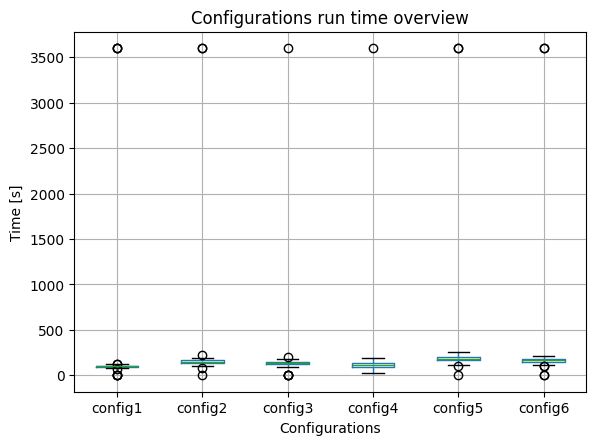

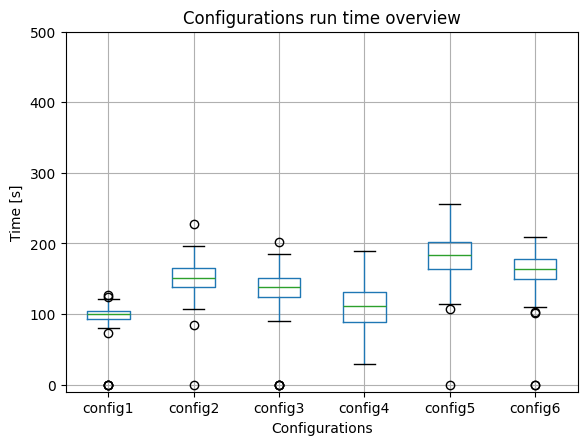

In [3]:
def box_plt(data: pd.DataFrame, **kwargs):
    box = data.boxplot("time", by="conf", **kwargs)
    box.set_title("Configurations run time overview")
    box.get_figure().suptitle("")  # remove "boxplot grouped ..." source: https://stackoverflow.com/a/23508225
    box.set_xlabel("Configurations")
    box.set_ylabel("Time [s]")

    return box

box_plt(df)
box = box_plt(df)
box.set_ylim(-10, 500)

df[(df["time"] == df["time"].max()) | (df["time"] == df["time"].min())]

__OTÁZKA K DOPLNĚNÍ:__

> _Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů?_

Áno, niektore merania majú v stĺpci `Time of run` extrémne hodnoty - `0.01` a `3600`. Pri výpise riadkov s týmito časmi môžme vidieť, že dôvod výskytu týchto extrémnych hodnôt nie je samotný algoritmus ale chyba počas jeho behu. Tieto hodnoty teda nepredstavujú reálny čas behu konfigurácie algoritmu ale slúžia na signalizáciu nevalidnych výsledkov.

* `SEGFAULT` - chyba nesprávneho prístupu do pamäte, keďže ale väčšina dat na túto chybu nenarazila, môžme predpokladať, že algoritmus obsahuje nejakú chybu v implementácii na ktorú narazí len niekedy. Vzhľadom na to, že budeme hodnotiť efektivitu algoritmu a nie jeho funkčnosť, môžme tieto hodnoty **ignorovať**.
* `TIME LIMIT` - chyba hovorí, že algoritmus nestihol dobehnúť do `3600` sekund. Na základe dostupných dat nevieme určiť, či sa jedná o chybu v implementácii alebo tu narážame na problem veľkého vstupu, to nakoniec ani nepotrebujeme vedieť. Keďže ale dĺžka behu väčšiny ostatných meraní je o viac ako rád nižšia, môžme predpokladať, že sa nejedná o bežnú situáciu a tieto hodnoty **ignorujeme**.

Takmer všetky konfigurácie obsahujú aj hodnoty mimo `3σ` pravidla, no vzhľadom na smerodajnú odchylku môžme predpokladať, že tieto dáta sú valídne a **ponecháme** ich.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

In [4]:
clean = df[(df["time"] != 3600) & (df["time"] != 0.01)]
clean.describe()

,time
count,1177.000000
mean,141.199038
std,36.834278
min,29.093401
25%,110.553018
50%,141.590868
75%,166.303874
max,255.807973


## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry času pro jednotlivé konfigurace.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
clean.groupby("conf").describe()

time                                                             \
         count        mean        std         min         25%         50%   
conf                                                                        
config1  193.0   99.590413   9.386788   73.802549   92.979469   99.865028   
config2  197.0  151.732975  19.833198   85.174653  137.995662  151.516091   
config3  195.0  138.616959  19.867428   90.567110  124.803901  138.678404   
config4  199.0  110.317016  30.656816   29.093401   88.742158  110.782732   
config5  197.0  183.659767  28.729836  107.283620  164.070091  183.843132   
config6  196.0  162.829359  20.648193  102.074892  149.917475  163.990098   

                                 
                75%         max  
conf                             
config1  104.824724  127.201692  
config2  163.802880  227.054630  
config3  151.536291  201.577616  
config4  130.665606  188.971462  
config5  201.250693  255.807973  
config6  177.730865  208.795048

__OTÁZKA K DOPLNĚNÍ:__

> _Okomentujte, co všechno můžeme z parametrů vyčíst._

Ako prvé si môžme všimnúť najdôležitejší fakt (bez ktorého by porovnanie veľký zmysel nedávalo) a to, že počet jednotlivých meraní, je približne rovnaký. 


Prvým faktom, ktorý môžme vyčítať je, že medián konfigurácie `1` je najnižší. To znamená, že pre priemernú úlohu riešenu algoritmom bude najrýchlejší. Taktiež môžme hovoriť aj o jeho stabilite - štandardná odchylka `~9.4` je vzhľadom na ostatné merania relatívne malá a dá sa teda očakávať, že dĺžka behu tejto konfigurácie nebude až tak kolísať.

Ďalším zaujimavým faktom ale je, že konfigurácia `4` má _zásadne_ kratšiu minimálnu dobu behu ako aj `25%` najrýchlejších behov je s touto konfiguráciou najrýchlejších. Ak predpokladáme, že týchto `25%` meraní bolo z kategoricky rovnakej skupiny úloh, môžme túto konfiguráciu vyhlásiť za najrýchlejšiu pre daný typ úlohy (napríklad ak týchto `25%` meraní obsahuje malé úlohy).



---
Malou úlohou je myslená malá veľkosť vstupných dat.

## Vizualizace
Vizualizujte časy běhů algoritmů v jednom kompaktním grafu tak, aby byl zřejmý i rozptyl hodnot. Zvolte vhodný graf, který pak níže komentujte.

(-10.0, 500.0)

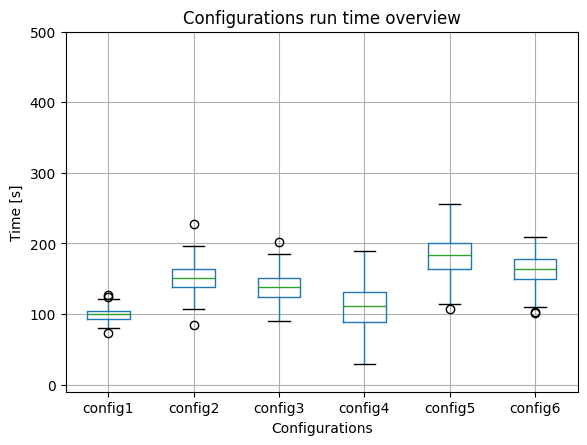

In [6]:
box = box_plt(clean)
box.set_ylim(-10, 500)

__OTÁZKA K DOPLNĚNÍ:__

> _Okomentujte  výsledky z tabulky._

Z grafu vyššie, tak isto ako aj z tabuľky s deskriptívnym popisom hodnôt vyplýva, že `config1` a `config4` majú najnižšie stredné hodnoty doby behu. Čo znamená, že priemerne sú najrýchlejšie.

Keďže ale `config4` má vysokú varianciu, nedá sa tak jednoducho určiť, ktorá konfigurácia je obecne rýchlejšia.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. Můžete i přidat další buňky.

Vužijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet studentova rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

> _Jaká data budete zkoumat?_


Keďže budeme analyzovať efektivitu konfigurácie algoritmu, bude nás zaujímať doba behu, teda čas, čo je spojitá veličina. Takže budeme analyzovať **spojité dáta**.

> _Jaké mají rozložení a parametry (např. varianci) a jaký test použijete?_

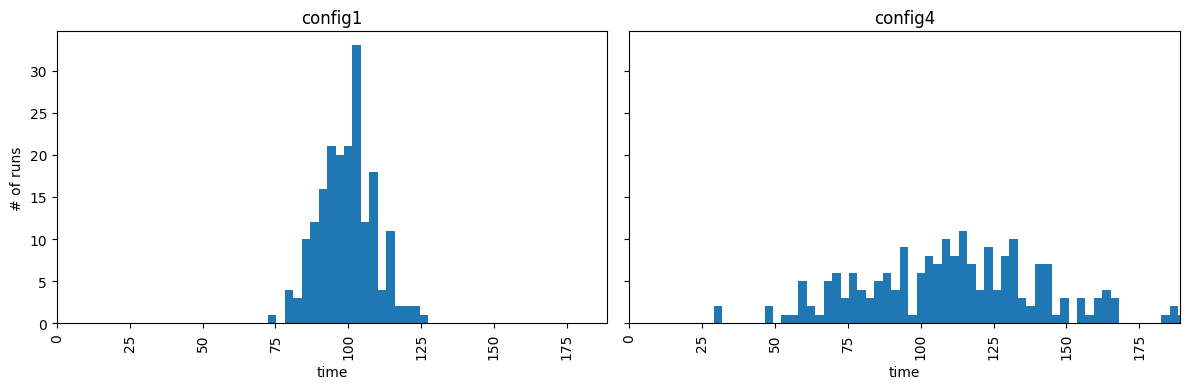

In [7]:
filtered = clean[(clean["conf"] == "config1") | (clean["conf"] == "config4")]

c1, c4 = filtered.hist("time", by="conf", bins=np.linspace(0, 200, 70), figsize=(12, 4), sharey=True)

c1.set_xlim(0, filtered["time"].max())
c4.set_xlim(0, filtered["time"].max())

c1.set_ylabel("# of runs")
c1.set_xlabel("time")
c4.set_xlabel("time")

c1.figure.tight_layout()

Ide o normálne rozloženie s nízkou resp. vysokou varianciou.

> parametry (např. varianci)

Normálne rozloženie má 2 parametre a to 
* strednú hodnotu `mean`
* štandardnú odchylku `std`

In [8]:
filtered.groupby("conf").describe().loc[:,(slice(None), ["mean", "std"])]  # multi-index indexing took from https://stackoverflow.com/a/64901648

time           
               mean        std
conf                          
config1   99.590413   9.386788
config4  110.317016  30.656816

Ďalej môžme určiť aj koeficienty skosenia:

In [9]:
print("config1", filtered[filtered["conf"] == "config1"]["time"].skew())
print("config4", filtered[filtered["conf"] == "config4"]["time"].skew())

config1 0.14170059122709824
config4 0.0492050464937537


Tie sú taktiež relatívne malé, čo len potvrdzuje, že ide o normálne rozloženie.

> _Jak se liší variabilita a poloha vybraných konfigurací?_

In [10]:
print(filtered[filtered["conf"] == "config1"]["time"].var())
print(filtered[filtered["conf"] == "config4"]["time"].var())

88.11179094342776
939.840347192918


Variabilita konfigurácií sa významne **líši**.

Keďže ide o normálne rozdelenie nezávyslých meraní, použijeme nepárový **Welchov t-test**.

> _Jaká je nulová hypotéza?_


H0:

  Stredné hodnoty behu konfigurácie 1 a 4 sa rovnajú.


H1:   

Stredná hodnota behu konfigurácie 1 je menšia než stredná hodnota behu konfigurácie 4 (1 je rýchlejšia ako 4).

In [11]:
res = stats.ttest_ind(
    filtered[filtered["conf"] == "config1"]["time"], 
    filtered[filtered["conf"] == "config4"]["time"], 
    equal_var=False, 
    alternative='less'  # doba behu 
)

__OTÁZKA K DOPLNĚNÍ:__

> _Jaký je závěr statistického testu?_

In [12]:
alpha = 0.05

if res.pvalue < alpha:
    print("Zamietame H0, platí H1", res.statistic, res.pvalue)
else:
    print("Nezamietame H0, nemôžeme teda potvrdiť H1.")


Zamietame H0, platí H1 -4.713292868840319 2.0843410569946737e-06


### Vlastná implementácia Welchovho t-testu

In [13]:
def welch_ttest(measurement1: pd.DataFrame, measurement2: pd.DataFrame):
    # Source https://real-statistics.com/students-t-distribution/two-independent-samples-t-test/two-sample-t-test-uequal-variances/
    m1_var = np.square(measurement1.std()) / measurement1.count()
    m2_var = np.square(measurement2.std()) / measurement2.count()
    
    variances_sum = m1_var + m2_var
    
    t = (measurement1.mean() - measurement2.mean()) / np.sqrt(variances_sum)
    d_o_freedom = np.square(variances_sum)  / (np.square(m1_var) / (measurement1.count() - 1) + np.square(m2_var) / (measurement2.count() - 1))

    return t, stats.t.cdf(t, d_o_freedom)

In [14]:
t, pval = welch_ttest(filtered[filtered["conf"] == "config1"]["time"], filtered[filtered["conf"] == "config4"]["time"])
t, pval

(-4.713292868840319, 2.0843410569946818e-06)

In [15]:
# Float comparison:
assert abs(t - res.statistic) <= 0.001
assert abs(pval - res.pvalue) <= 0.001

Vlastná a referenčná implementácia Welchovho t-testu vracia rovnaké výsledky (odhliadnúc od chyby spôsobenej počítaním s floating-point číslami).